In [1483]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import vtreat

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import seaborn as sns
#Metric
from sklearn.metrics import r2_score

#Stat
from scipy.stats import skew, kurtosis
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
#Warning Disable
import warnings
warnings.filterwarnings("ignore")

In [666]:
!ls

data_description.txt  sample_submission.csv train.csv
main.ipynb            test.csv


In [1496]:
#Custome RSME scoring function 
def log_rmse_cv(estimator, x, y):
    yPred = estimator.predict(x)
    log_y = np.log(y)
    log_yPred = np.log(yPred)
    score=np.sqrt(np.sum(np.square(log_y-log_yPred))/len(y))
    return score

In [1151]:
#Custome RSME scoring function with np.expm1
def exp_log_rmse_cv(estimator, x, y):
    yPred = estimator.predict(x)
    yPred=np.expm1(yPred)
    log_y = np.log(y)
    log_yPred = np.log(yPred)
    score=np.sqrt(np.sum(np.square(log_y-log_yPred))/len(y))
    return score

In [1204]:
np.expm1(np.log1p(2))

2.0000000000000004

In [668]:
#CV always return the max score, but we want the min score
def get_min_score_param(mod_search):
    min_index=mod_search.cv_results_['mean_test_score'].argmin()
    min_score=mod_search.cv_results_['mean_test_score'][min_index]
    print("The min score is:",min_score )
    return gs_xgb.cv_results_['params'][min_index]

In [752]:
def cat_object(df):
    cat_obj=[]
    for i in df.columns:
        if df[i].dtype=='O':
            cat_obj.append(i)
    return cat_obj

In [835]:
def feature_analysis(df,col):
    return df.groupby(col).agg(["mean","count","median"]).SalePrice

In [818]:
def nan_(df):
    fool=df.isna().sum()
    count=0
    for i in df.columns:
        if fool[i]>0:
            print(i,fool[i])
            count+=1
    print(count)

# Prepare the Data

In [1435]:
#Data 
df=pd.read_csv("train.csv")
df.head()
X=df.drop(['SalePrice','Id'],axis=1)
y=df['SalePrice']

X_train, X_test, y_train , y_test = train_test_split(X,y,random_state=1)

X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

In [432]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


# 1) Baseline model with v_treat and XG_Boost

Since the X_train_new created 201 columns, which is a sparsed matrix (have a lot of 0). I have to convert from sparse to dense matrix to avoid messingup XGBoost. 

Note: Have tried pca(preserve 95% variance) and get 0.20850013615758403. But pca mess up one hot encoding columns.


In [433]:
#Processing train set and test set
start = time.time()

plan = vtreat.NumericOutcomeTreatment()
X_train_new = plan.fit_transform(X_train,y_train)
X_train_new=X_train_new.values.astype('f4')

X_test_new=plan.transform(X_test)
X_test_new=X_test_new.values.astype('f4')

end = time.time()
print(end - start)

14.48937702178955


In [235]:
# pca=PCA(n_components=.95)
# X_train_new=pca.fit_transform(X_temp1)

# plan.score_frame_

In [237]:
print(X_train_new.shape)
print(X_train.shape)

(1095, 203)
(1095, 79)


### XGBoost

In [239]:
#Set objective ='reg:squarederror' to turn off warning
#0.13981006472136315
clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,learning_rate=0.05) 
clf.fit(X_train_new,y_train)

y_test_predicts = clf.predict(X_test_new)

np.mean(cross_val_score(clf,X_test_new,y_test, scoring=log_rmse_cv,cv=5))

0.13981006472136315

### Tuning

In [241]:
param_grid={ "objective" : ['reg:squarederror'],
            "max_depth" : [3,4],
            "learning_rate" :[0.1,0.2],
            "n_estimators" : [100,300,700],
            "min_child_weight" :[1,2]
}
start = time.time()

gs_xgb = GridSearchCV(clf, param_grid, cv=5,scoring=log_rmse_cv,return_train_score=True,refit=False)
gs_xgb.fit(X_test_new, y_test)

end = time.time()
print(end-start)

160.08213090896606


In [243]:
#0.139306894547945
# {'learning_rate': 0.1,
#  'max_depth': 3,
#  'min_child_weight': 1,
#  'n_estimators': 300,
#  'objective': 'reg:squarederror'}

# The min score is: 0.14034943641076741
# {'learning_rate': 0.1,
#  'max_depth': 3,
#  'min_child_weight': 1,
#  'n_estimators': 300,
#  'objective': 'reg:squarederror'}

get_min_score_param(gs_xgb)

The min score is: 0.14034943641076741


{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 300,
 'objective': 'reg:squarederror'}

# 2) Manually cleaning data

### Create DataFrame

In [1527]:
df_Temp=df.copy()
df_Temp=df_Temp.drop(["Id","SalePrice"],axis=1)

In [1528]:
df_Temp.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Fill nan

In [1529]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
df_Temp['MSSubClass'] = df_Temp['MSSubClass'].apply(str)
df_Temp['YrSold'] = 2019-df_Temp['YrSold']

In [1530]:
dffool=df_Temp.groupby("MoSold").size()/len(df_Temp) #Group it by type, find the size of each type, and divide by total event
df_Temp['MoSold']=df_Temp['MoSold'].map(dffool)

In [1531]:
#Filling cat columns with mode (norminal)
df_Temp['Functional'] = df_Temp['Functional'].fillna('Typ')
df_Temp['Electrical'] = df_Temp['Electrical'].fillna("SBrkr") #Standard Circuit Breakers & Romex (1335 values)
df_Temp['KitchenQual'] = df_Temp['KitchenQual'].fillna("TA") #The most occurence (735) also average
df_Temp['Exterior1st'] = df_Temp['Exterior1st'].fillna('VinylSd') #515 average type
df_Temp['Exterior2nd'] = df_Temp['Exterior2nd'].fillna('VinylSd') #504 average type
df_Temp['SaleType'] = df_Temp['SaleType'].fillna("WD") #1267
df_Temp['MSZoning']=df_Temp['SaleType'].fillna("RL") #1151

In [1532]:
df_Temp["PoolQC"] = df_Temp["PoolQC"].fillna("None")

In [1533]:
#These are feature that have many type
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df_Temp[col] = df_Temp[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df_Temp[col] = df_Temp[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_Temp[col] = df_Temp[col].fillna('None')

In [1534]:
#Some domain knowledge here. 
df_Temp['LotFrontage'] = df_Temp.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [1535]:
#Fill the rest of the na value by None
cat_cols=cat_object(df_Temp)
df_Temp.update(df_Temp[cat_cols].fillna('None'))

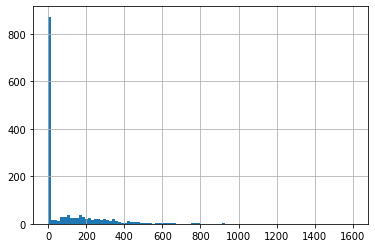

In [1536]:
#Fill MasVnrArea by its mode
df_Temp["MasVnrArea"]=df_Temp["MasVnrArea"].fillna(0)
df_Temp["MasVnrArea"].hist(bins=100)

In [1537]:
#There is no more nan
nan_(df_Temp)

0


### Check normal distributivity

**Skewness** 
Dealing with extreme long/short tails on both sides
* $(-0.5,0.5)$: symmetrical
* $(-1,-0.5)$ : moderatedly negative skew
* $(0.5,1)$: moderatedly positive skew
* More or less than that: highly skew



In [1538]:
num_cols=list(set(df_Temp.columns)-set(cat_cols))

skewness_num_feature = df_Temp[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

In [1539]:
high_skew = skewness_num_feature[skewness_num_feature > 0.5]
skew_index = high_skew.index

for i in skew_index:
    df_Temp[i] = boxcox1p(df_Temp[i], boxcox_normmax(df_Temp[i] + 1))

**Kurtosis**
Dealing with extreme long/short tails on both sides

* Mesokurtic(kurtosis~3): Good. SND has kurtosis -3
* Platykurtic (kurtosis<3): short tails
* Leptokurtic (kurtosis>3): long tails

In [1540]:
krt_num_feature = df_Temp[num_cols].apply(lambda x: kurtosis(x)).sort_values(ascending=False)

In [1541]:
#Not sure how to deal with these yet

In [1542]:
nan_(df_Temp)

0


### Some analysis

Ord= ExterQual,ExterCond, BsmtQual, BsmtCond, BsmtExposure,BsmtFinType1,BsmtFinType2,KitchenQual,FireplaceQu, GarageType,GarageFinish,GarageQual,GarageCond, PavedDrive, MSZoning, Fence


Combine: 
Total_sqr_footage=BsmtFinSF1+BsmtFinSF2+1stFlrSF+2ndFlrSF
Total_Bathrooms=FullBath+0.5*HalfBath+ BsmtFullBath+0.5*BsmtHalfBath
Total_porch_sf=OpenPorchSF+3SsnPorch+EnclosedPorch+ScreenPorch+WoodDeckSF
YrBltAndRemod=YearBuilt+YearRemodAdd (since yearremod same as construction date if no remodeling or additions)
Overallscore=OverallQual+OverallCond

1,0- on and hot encode

Maybe 2ndFlrSF (Since there are 829/1460 houses has 0 2nd floor)
MiscFeature (Elevator, Gar2, Othr, Shed, TenC)

Remove:
Utilities (since 1459 all pub and 1 NoSeWa)
Street (Since 1454 pave and 9 Grvl)
PoolQC (Since there are only 7 houses have pool)
PoolArea (Since the unique value range from 512 to 738 and 1453/1459 has no pool )
Alley (50 Grvl, 41 pavement)

Others: 
Throw to vtreat

In [1463]:
#I did not map NA since Vtreat will help me do it
#BsmtExposure,BsmtFinType1,BsmtFinType2,KitchenQual,FireplaceQu, 
#GarageFinish,GarageQual,GarageCond, PavedDrive, Fence

grade_map={"None":0,"Po":1, "Fa":2,"TA":3,"Gd":4,"Ex":5}
cols1=["ExterQual","ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond"]
for i in cols1:
    df_Temp[i]=df_Temp[i].map(grade_map)

exposure_map={"Gd":4,"Av":3,"Mn":2, "No":0, "NA":0,"None":0}
df_Temp["BsmtExposure"]=df_Temp["BsmtExposure"].map(exposure_map)

bsmt_map={"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1, "NA":0,"None":0}
cols2=["BsmtFinType1"]
for i in cols2:
    df_Temp[i]=df_Temp[i].map(bsmt_map)

garage_map={"Fin":3,"RFn":2,"Unf":1,"NA":0,"None":0}
df_Temp["GarageFinish"]=df_Temp["GarageFinish"].map(garage_map)


pavement_map={"Y":2,"P":1,"N":0,"None":0}
df_Temp["PavedDrive"]=df_Temp["PavedDrive"].map(pavement_map)

cols_orinal=cols1+["BsmtExposure"]+cols2+["GarageFinish"]+["PavedDrive"]


In [1464]:
print(nan_(df_Temp))

0
None


### Combine

In [1465]:
df_Temp['YrBltAndRemod']=df_Temp['YearBuilt']+df_Temp['YearRemodAdd']
df_Temp['TotalSF']=df_Temp['TotalBsmtSF'] + df_Temp['1stFlrSF'] + df_Temp['2ndFlrSF']

df_Temp['Total_sqr_footage'] = (df_Temp['BsmtFinSF1'] + df_Temp['BsmtFinSF2'] +
                                 df_Temp['1stFlrSF'] + df_Temp['2ndFlrSF'])

df_Temp['Total_Bathrooms'] = (df_Temp['FullBath'] + (0.5 * df_Temp['HalfBath']) +
                               df_Temp['BsmtFullBath'] + (0.5 * df_Temp['BsmtHalfBath']))

df_Temp['Total_porch_sf'] = (df_Temp['OpenPorchSF'] + df_Temp['3SsnPorch'] +
                              df_Temp['EnclosedPorch'] + df_Temp['ScreenPorch'] +
                              df_Temp['WoodDeckSF'])

In [1466]:
print(nan_(df_Temp))

0
None


### Simplify feature

In [1467]:
df_Temp['haspool'] = df_Temp['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_Temp['has2ndfloor'] = df_Temp['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_Temp['hasgarage'] = df_Temp['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_Temp['hasbsmt'] = df_Temp['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_Temp['hasfireplace'] = df_Temp['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### Remove Overfit

In [1468]:
#Remove everything with one category more than 99.5 percent
overfit = []
for col in df_Temp.columns:
    most_counts = df_Temp[col].value_counts()
    most_counts_value = most_counts.iloc[0]
    if most_counts_value / len(df_Temp) * 100 > 99.5:
        overfit.append(col)

overfit = list(overfit)
overfit

['Street', 'Utilities', 'PoolArea', 'PoolQC', 'haspool']

In [1469]:
df_Temp = df_Temp.drop(overfit, axis=1)

### Throw everything in vtreat

In [1500]:
#Processing train set and test set
start = time.time()

plan = vtreat.NumericOutcomeTreatment()
X_temp = plan.fit_transform(df_Temp,df["SalePrice"])

end = time.time()
print(end - start)

3.5813968181610107


In [1502]:
df_Temp.shape

(1460, 268)

In [1503]:
# leftover_cat=cat_object(df_Temp)
# num_cols=list(set(df_Temp.columns)-set(leftover_cat))

# dffool=pd.get_dummies(df_Temp[leftover_cat])
# df_Temp=pd.concat([df_Temp[num_cols],dffool],axis=1)

In [1504]:
df_Temp.shape

(1460, 268)

### Normalize

In [1505]:
scaler = MinMaxScaler()
scaler.fit(df_Temp)
dffool=scaler.transform(df_Temp)
df_final=pd.DataFrame(dffool,columns=df_Temp.columns)
df_final.shape

(1460, 268)

In [1506]:
df_final.head()

,FireplaceQu,TotalBsmtSF,ScreenPorch,GarageYrBlt,GarageArea,YearBuilt,GarageFinish,OverallQual,KitchenAbvGr,WoodDeckSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.213651,0.0,0.996517,0.386460,0.949275,0.666667,0.666667,0.482938,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.6,0.289913,0.0,0.983085,0.324401,0.753623,0.666667,0.555556,0.482938,0.495379,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.6,0.226119,0.0,0.995522,0.428773,0.934783,0.666667,0.666667,0.482938,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.8,0.193755,0.0,0.994030,0.452750,0.311594,0.333333,0.666667,0.482938,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.6,0.268568,0.0,0.995025,0.589563,0.927536,0.666667,0.777778,0.482938,0.368892,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Prepare data

In [1507]:
X=df_final
y=df.SalePrice
X_train, X_test, y_train , y_test = train_test_split(X,y,random_state=1)

X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

### Prediction

In [1508]:
X_train=X_train.values.astype('f4')
X_test=X_test.values.astype('f4')

In [1513]:
clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,learning_rate=0.05,max_depth=3,min_child_weight=1) 
clf.fit(X_train,y_train)

np.mean(cross_val_score(clf,X_test, y_test, scoring=log_rmse_cv,cv=3))

0.1513712023205992

In [1307]:
start = time.time()

gs_xgb = GridSearchCV(clf, param_grid, cv=5,scoring=log_rmse_cv,return_train_score=True,refit=False)
gs_xgb.fit(X_test_new, y_test)

end = time.time()
print(end-start)

126.15706419944763


In [1308]:
get_min_score_param(gs_xgb)

The min score is: 0.14255732994188786


{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 300,
 'objective': 'reg:squarederror'}

In [ ]:
#0.1364023282041639
#n_estimators=1000,learning_rate=0.05,max_depth=3,min_child_weight=1

In [1546]:
def Stefan(n):
    combinations = (map(operator.sub, cuts + (n,), (0,) + cuts)
                    for cuts in itertools.combinations_with_replacement(range(n+1), 3))
    return [c for c in combinations if max(c) < n]

In [1559]:
def drum(n):
    out = []
    for a in range(n):
        for b in range(n):
            for c in range(n):
                for d in range(n):
                    for e in range(n):
                        for f in range(n):
                            if (a + b + c + d+e+f== n) & (a*b*c*d*e*f)!=0:
                                out.append((a, b, c, d, e, f))
    return out

In [ ]:
drum(50)

In [1550]:
a=Stefan(5)

In [1553]:
type(a[1])

map

In [ ]:
y_test_predicts

In [1310]:
pd.get_dummies(df_Temp).reset_index(drop=True).shape

(1460, 283)